<a href="https://colab.research.google.com/github/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/blob/main/RUN_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2022-06-29 06:42:05--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  47.0MB/s    in 5.4s    

2022-06-29 06:42:10 (44.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2022-06-29 06:42:11--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      


#1. SO SÁNH GIỮA GRABCUT VÀ GRABCUT + SLIC

Ở đây chúng ta sẽ so sánh giữa grabcut và grabcut + SLIC superpixel segmentation

In [ ]:
from skimage.segmentation import slic
import cv2
import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/0/05/Cow-bw.JPG

--2022-06-25 13:58:30--  https://upload.wikimedia.org/wikipedia/commons/0/05/Cow-bw.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5595095 (5.3M) [image/jpeg]
Saving to: ‘Cow-bw.JPG’

Cow-bw.JPG          100%[===================>]   5.33M  18.2MB/s    in 0.3s    

2022-06-25 13:58:30 (18.2 MB/s) - ‘Cow-bw.JPG’ saved [5595095/5595095]



In [ ]:
def load_model(Image):
    ''' 
    Load YOLOv3 model and detect objects
    outs: list of detected objects
    '''
    try:
        configuration = "yolov3.cfg"
        weights = "yolov3.weights"
        classesFile = "coco.names"
        classes = None
    
        with open(classesFile, 'rt') as f:
            classes = f.read().rstrip('\n').split('\n')

        net = cv2.dnn.readNetFromDarknet(configuration, weights)
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    except:
        print("Error: Cannot load model")
        sys.exit()
    try:
        inputWidth,inputHeight=608,608
        blob = cv2.dnn.blobFromImage(Image, 1 / 255, (inputWidth, inputHeight), [0, 0, 0], 1, crop=False)
        net.setInput(blob)
        layersNames = net.getLayerNames()
        outs = net.forward([layersNames[index[0] - 1] for index in net.getUnconnectedOutLayers()])
    except:
        print("Error: Cannot detect objects")
        sys.exit()
    return outs
    
def postprocess(frameHeight, frameWidth, outs,confThreshold=0.0):
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                boxes.append([left, top, width, height])
    return boxes
def create_segmentation_mask(label,segmented,seg_mask,outline):
    '''
    Create segmentation mask
    Parameters:
    ----
    label: label of segment
    segmented: segmented image
    seg_mask: segmentation mask
    outline: outline of segment
    return 
    seg_mask: segmentation mask
    '''
    for index in range(0, len(label)):
        if label[index] == 0:
            temp = outline == segmented[index]
            seg_mask = seg_mask + temp
    return seg_mask

In [ ]:
def Grab_Mask_without_SLIC(img):
    Image=img.copy()
    Width, Height = Image.shape[1], Image.shape[0]
    #load model
    outs= load_model(Image)
    #Box of Object
    boxes = postprocess(Height, Width, outs)
    if len(boxes):
        [left, top, width, height] = boxes[0]
    else:
        [left, top, width, height] = [0, Height, Width, Height]
    mask = np.zeros(Image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = [left, top, left + width, top + height]
    cv2.grabCut(Image, mask, rect, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)
    cv2.grabCut(Image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
    grabMask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    return grabMask

def Grab_Mask_with_SLIC(img):
    if img.shape[0]*img.shape[1]>10000000:
        segmentSize=int(5+2.5*(img.shape[0]*img.shape[1]-1000000)//1000000)
    else:
        segmentSize=5
    Image=img.copy()
    Width, Height = Image.shape[1], Image.shape[0]
    outline=slic(img,n_segments=int(np.ceil(float(Width*Height)/float(segmentSize**2))))
    #load model
    outs= load_model(Image)
    #Box of Object
    boxes = postprocess(Height, Width, outs)
    if len(boxes):
        [left, top, width, height] = boxes[0]
    else:
        [left, top, width, height] = [0, Height, Width, Height]
        #Grab Cut
    mask = np.zeros(Image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = [left, top, left + width, top + height]
    cv2.grabCut(Image, mask, rect, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)
    cv2.grabCut(Image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

    grabMask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented = np.unique(grabMask * outline)
    segmented = segmented[1 : len(segmented)]
    pxtotal = np.bincount(outline.flatten())
    pxseg = np.bincount((grabMask * outline).flatten())
    seg_mask = np.zeros(Image.shape[:2], np.uint8)
    label = (pxseg[segmented] / pxtotal[segmented].astype(float)) < 0.25
    seg_mask=create_segmentation_mask(label,segmented,seg_mask,outline)
    
    #Graussian Blur
    try:
        seg_mask = cv2.GaussianBlur(seg_mask, (segmentSize,segmentSize), 0)
    except:
        seg_mask = cv2.GaussianBlur(seg_mask, (segmentSize+1,segmentSize+1), 0)
    # Meger segmentation mask with original image
    return seg_mask

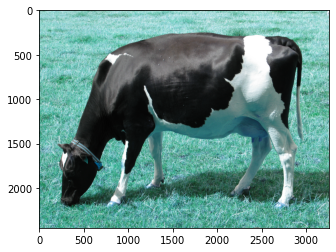

In [ ]:
img=cv2.imread("/content/Cow-bw.JPG")
plt.imshow(img)

In [ ]:
Grab_mask_without_SLIC=Grab_Mask_without_SLIC(img)

In [ ]:
Grab_mask_with_SLIC=Grab_Mask_with_SLIC(img) #25p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


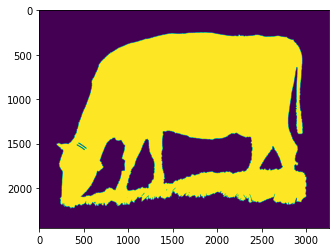

In [ ]:
#visualization
plt.imshow(Grab_mask_without_SLIC)

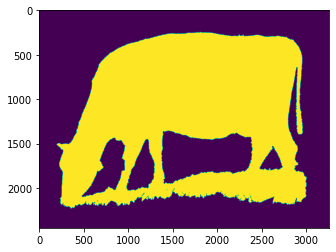

In [ ]:
plt.imshow(Grab_mask_with_SLIC)

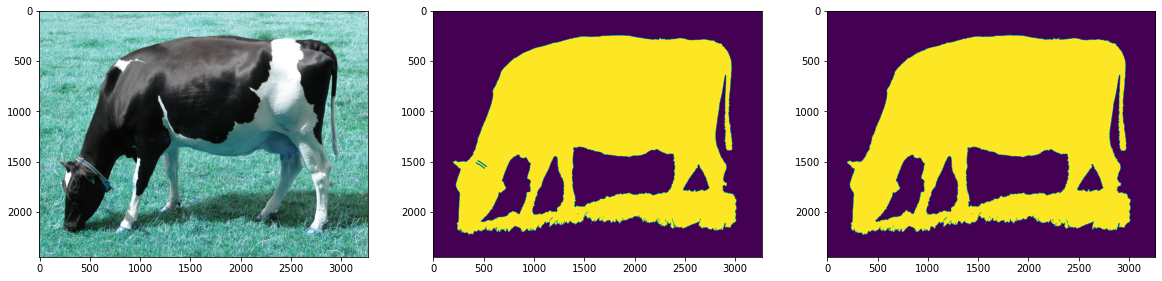

In [ ]:
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(1, 3, 1)
plt.imshow(img)
fig.add_subplot(1, 3, 2)
plt.imshow(Grab_mask_without_SLIC)
fig.add_subplot(1, 3, 3)
plt.imshow(Grab_mask_with_SLIC)
plt.show()

# 2. Thời gian chạy thử

In [ ]:
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Dog.JPG
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Cow_1.png
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Landmark.png
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Cow-bw.JPG
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/sequential.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/seq_jit.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/seq_jit_v2.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/Parallel_v1.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/parallel_v2.py

--2022-06-29 09:01:03--  https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Dog.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15302 (15K) [image/jpeg]
Saving to: ‘Dog.JPG’

Dog.JPG             100%[===================>]  14.94K  --.-KB/s    in 0s      

2022-06-29 09:01:03 (119 MB/s) - ‘Dog.JPG’ saved [15302/15302]

--2022-06-29 09:01:03--  https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Cow_1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, aw

### Non jit

In [ ]:
%%time
!python /content/sequential.py /content/Dog.JPG

CPU times: user 999 ms, sys: 175 ms, total: 1.17 s
Wall time: 3min 47s


### jit version 1

In [ ]:
%%time
!python /content/seq_jit.py /content/Dog.JPG

CPU times: user 862 ms, sys: 117 ms, total: 980 ms
Wall time: 3min 10s


### parallel version 1

In [ ]:
%%time
!python /content/Parallel_v1.py /content/Dog.JPG

CPU times: user 913 ms, sys: 143 ms, total: 1.06 s
Wall time: 3min 10s


### jit version 2

In [ ]:
%%time
!python /content/seq_jit_v2.py /content/Dog.JPG

CPU times: user 375 ms, sys: 55.8 ms, total: 431 ms
Wall time: 1min 11s


### parallel version 2

In [ ]:
%%time
!python /content/parallel_v2.py /content/Dog.JPG

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
CPU times: user 106 ms, sys: 20 ms, total: 126 ms
Wall time: 16.1 s


# 3. Thời gian chạy từng phần

In [ ]:
%%capture

!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Dog.JPG
import matplotlib.pyplot as plt
import cv2
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/test/sequential_test.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/test/seq_jit_test.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/test/seq_jit_v2_test.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/test/Parallel_v1_test.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/test/parallel_v2_test.py


### Non jit

In [ ]:
!python /content/sequential_test.py /content/Dog.JPG

Load model:  5.366687297821045
SLIC:  229.241366147995
Grab Cut:  1.532203197479248
Segmentation Mask:  0.5542161464691162
Gaussian Blur:  0.008498907089233398
Merge Mask:  0.5713253021240234


### jit version 1


In [ ]:
!python /content/seq_jit_test.py /content/Dog.JPG

Load model:  4.37872314453125
SLIC:  178.28586959838867
Grab Cut:  1.536797285079956
Segmentation mask:  0.3550121784210205
Graussian Blur:  2.5986344814300537
Meger mask:  0.23261499404907227


### Parallel version 1

In [ ]:
!python /content/Parallel_v1_test.py /content/Dog.JPG

Load model:  4.34298300743103
SLIC:  179.1428439617157
Grab Cut:  1.5380544662475586
Segmentation Mask:  0.5275263786315918
Graussian Blur:  2.659306526184082
Meger Mask:  0.22211194038391113


### jit version 2

In [ ]:
!python /content/seq_jit_v2_test.py /content/Dog.JPG

Load model:  4.385105609893799
SLIC:  61.6146674156189
Grab Cut:  1.5340099334716797
Segmentation mask:  1.1550869941711426
Graussian Blur:  2.3493688106536865
Meger mask:  0.22896289825439453


### parallel version 2

In [ ]:
!python /content/parallel_v2_test.py /content/Dog.JPG

Load model:  4.269040107727051
SLIC:  5.457174301147461
Grab cut:  1.5141315460205078
Segmentation mask:  1.4095072746276855
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Gaussian blur:  1.020664930343628
Meger mask:  0.8463740348815918


# 4. So sánh thời gian chạy của parallel version 2 và jit version 2 đối với những hình ảnh lớn hơn

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Cow_1.png
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/input%20image/Cow-bw.JPG
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/test/parallel_v2_test_2.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/test/seq_jit_v2_test_2.py

### jit version 2

In [ ]:
!python /content/seq_jit_v2_test_2.py /content/Cow_1.png

Load model:  4.339108228683472
SLIC:  592.057457447052
Grab Cut:  18.559415817260742
Segmentation mask:  2.4602255821228027
Graussian Blur:  6.967015027999878
Meger mask:  0.357041597366333


In [ ]:
!python /content/seq_jit_v2_test_2.py /content/Cow-bw.JPG

Load model:  4.334352731704712
/content/seq_jit_v2_test_2.py:513: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  outline = segmentation.slic(Image,n_segments=16060)
SLIC using skimage:  124.25840377807617
Grab Cut:  54.26280403137207
Segmentation mask:  19.61158585548401
Graussian Blur:  66.00718235969543
Meger mask:  0.7620925903320312


### parallel version 2

In [ ]:
!python /content/parallel_v2_test_2.py /content/Cow_1.png

Load model:  4.326554775238037
SLIC:  10.65176510810852
Grab cut:  18.79040551185608
Segmentation mask:  2.8139357566833496
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Gaussian blur:  1.137239933013916
Meger mask:  0.8119826316833496


In [ ]:
!python /content/parallel_v2_test_2.py /content/Cow-bw.JPG

Load model:  4.326153755187988
SLIC:  274.9980721473694
Grab cut:  57.38727140426636
Segmentation mask:  21.606531858444214
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Gaussian blur:  1.4840655326843262
Meger mask:  1.2000360488891602
